In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
import kagglehub
import os
import missingno as msno
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

TODO:

1. Generate final dataset (deal with scaling, missingness, imbalance)
2. EDA (statistics and plots)
  - shape of the data, data types, and descriptive statistics such as `mean`, `max`, and `dtypes`.
  - Additionally, you should provide a summary of the features of the data, including histograms, correlation plots, and clustering plots.
3. Deeper Understanding of the Data.
  - Should aim to provide a deeper understanding of the data through your analysis. This can be achieved by identifying patterns, trends, class imbalances, and outliers in the data.
  - Additionally, explore the relationships between variables and identify any potential confounding variables that may impact the analysis.



### Generate final dataframe

In this session, we dealt we all the missingness, encoded categorical data with numbers, and standardized the numerical values.

In [2]:
#Download Dataset from Kaggle
path = kagglehub.dataset_download("redwankarimsony/heart-disease-data")
df = pd.read_csv(os.path.join(path,"heart_disease_uci.csv"))

In [3]:
#Examine Repsonse Variable ('Num')
df['num'].value_counts()

num
0    411
1    265
2    109
3    107
4     28
Name: count, dtype: int64

We are interested in predicting the presence of heart disease rather than "staging" heart disease. As such, we will plan to convert the response variable 'num' to a binary variable 0 vs 1. This approach is consistent with the approach taken by the dataset authors [[1]](https://link.springer.com/chapter/10.1007/978-3-030-33327-0_12) and in line with our clinical experience.

In [4]:
# convert response variable (1-4) to 1, keep 0
df['heart_disease'] = df['num'].apply(lambda x: 1 if x != 0 else 0)

In [5]:
#Create Backup Copy of df
df_clean = df.copy()

We first examine our dataset to understand the missingness of our data:

<Axes: >

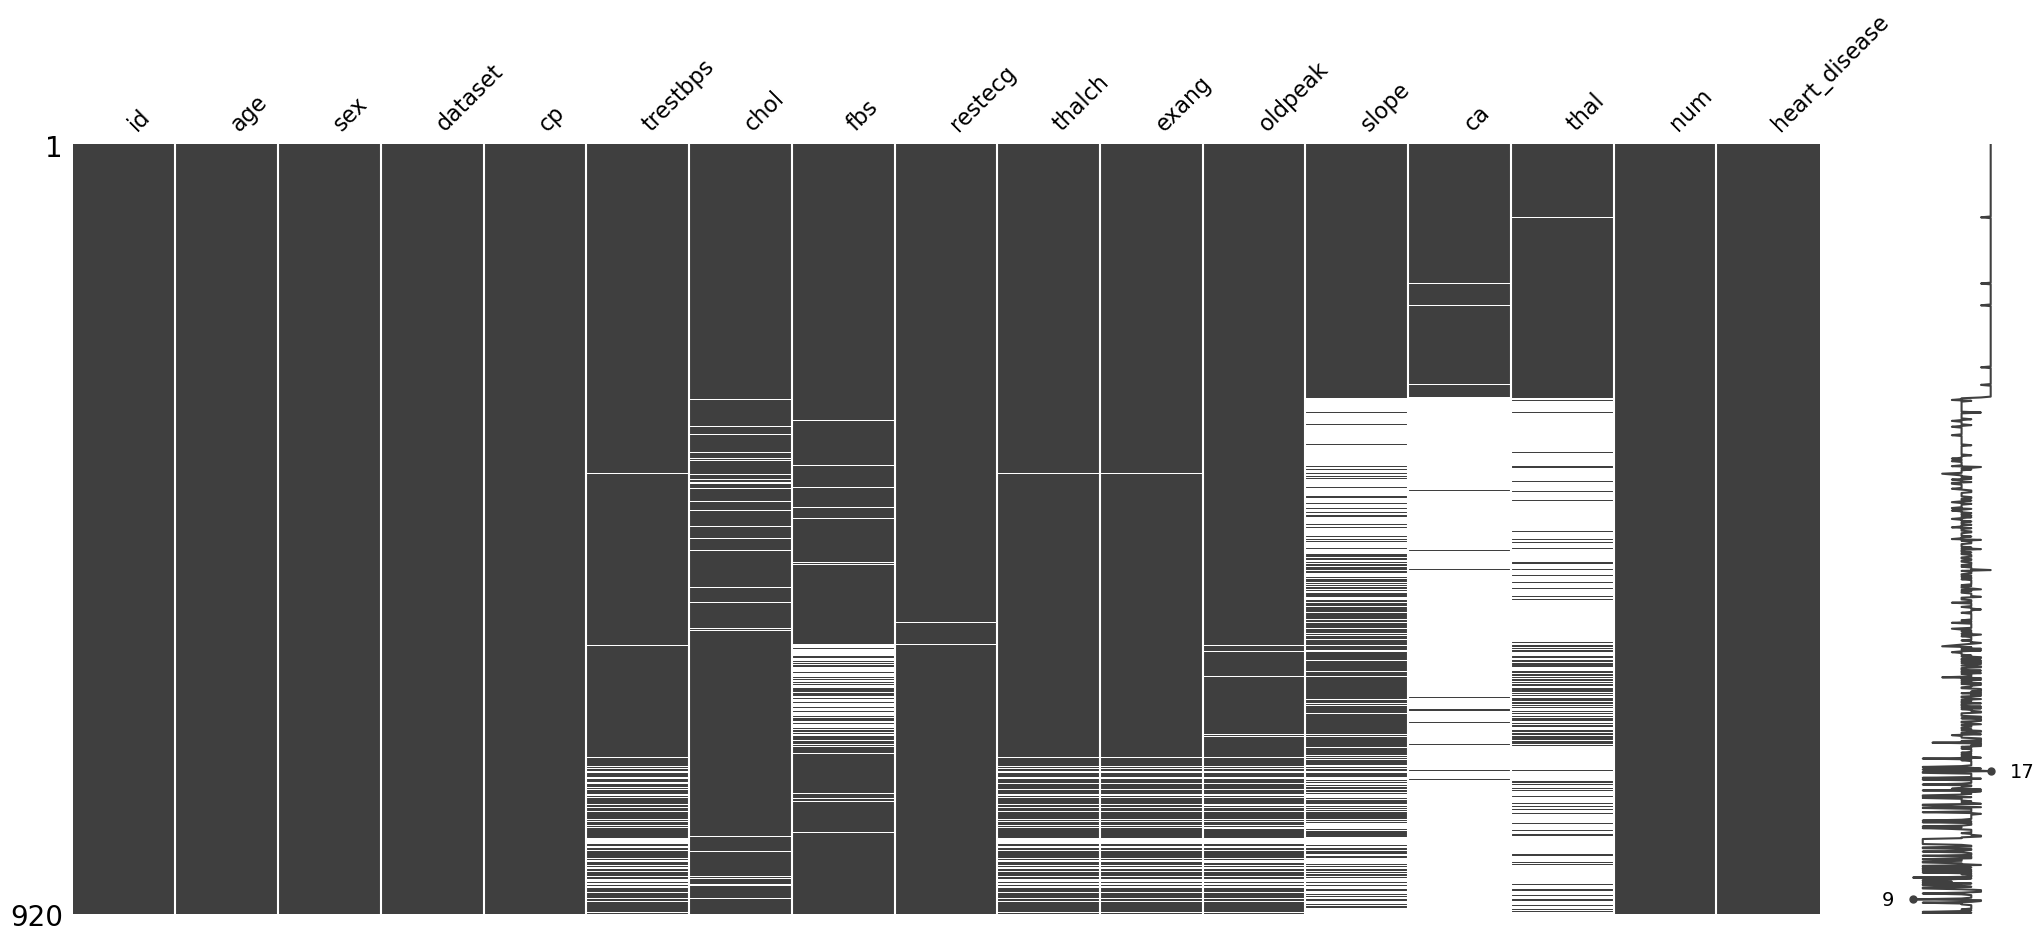

In [6]:
msno.matrix(df)

**From the plot above, we see specific patterns of missingness:**

1. 'chol' and 'fbs' - These measure serum cholesterol and an indicator of if fasting blood sugar is > 120 mg/dl. It is highly unlikely that these data were not measured for the subject at present and likely represent missingness completely at random.

2. 'restecg' - Only two values are missing.

3. 'trestbps', 'thalch', 'exang', and 'oldpeak' - These variables are measured during a stress test performed on a treadmill. Those with missing values likely did not undergo exercise stress testing.

4. 'ca' - This is the number of major blood vessels that are opacified during an invasive cardiac procedure—coronary angiography (also known as catheterization). Patients who undergo a catheterization are different from those who do not—often they had concerning features on a stress test or symptoms of a heart attack.

5. 'thal' - This signifies patient stress test results as a categorical variable. Patients referred for a stress test are likely different based on symptom burden, risk factors, and other important clinical characteristics.

In [7]:
#Impute 'chol' and 'fbs'
met_columns = ['age','sex','dataset','chol','fbs']

#convert 'dataset' to numeric (won't convert to dummy variables, as we won't use for prediction in the future)
df['dataset'] = df['dataset'].astype('category').cat.codes

#Need to convert 'sex' column to numerical to work with KNN (Male -> 1, Female -> 0)
df['sex'] = df['sex'].map({'Male': 1, 'Female': 0})

# Create missingness indicator variables
df['chol_missing'] = df['chol'].isnull().astype(int)
df['fbs_missing'] = df['fbs'].isnull().astype(int)

# Grab columns
met_data = df[met_columns]

# Initialize KNN Imputer (trial with n_neighbors as 5 --- we may need to experiment with adjusting this)
imputer = KNNImputer(n_neighbors=5)

#impute
imputed_met_data = imputer.fit_transform(met_data)

#Replace df_columns
df[met_columns] = imputed_met_data

In [8]:
#Get mode of 'rest_ecg'
rest_ecg_mode = df['restecg'].mode()[0]

#Impute missing values in 'rest_ecg' with the mode
df['restecg'] = df['restecg'].fillna(rest_ecg_mode)

In [9]:
# Create missingness indicator variables
df['trestbps_missing'] = df['trestbps'].isnull().astype(int)
df['thalch_missing'] = df['thalch'].isnull().astype(int)

#Impute 'trestbps' and 'thalch' from Exercise Treadmill Tests (ie 'ett')
ett_columns = ['age','sex','trestbps','thalch']

#grab columns
ett_data = df[ett_columns]

#Initialize KNN Imputer (trial with n_neighbors as 5 --- we may need to experiment with adjusting this)
imputer = KNNImputer(n_neighbors=5)

#Impute
imputed_ett_data = imputer.fit_transform(ett_data)

#Replace df_columns
df[ett_columns] = imputed_ett_data


<Axes: >

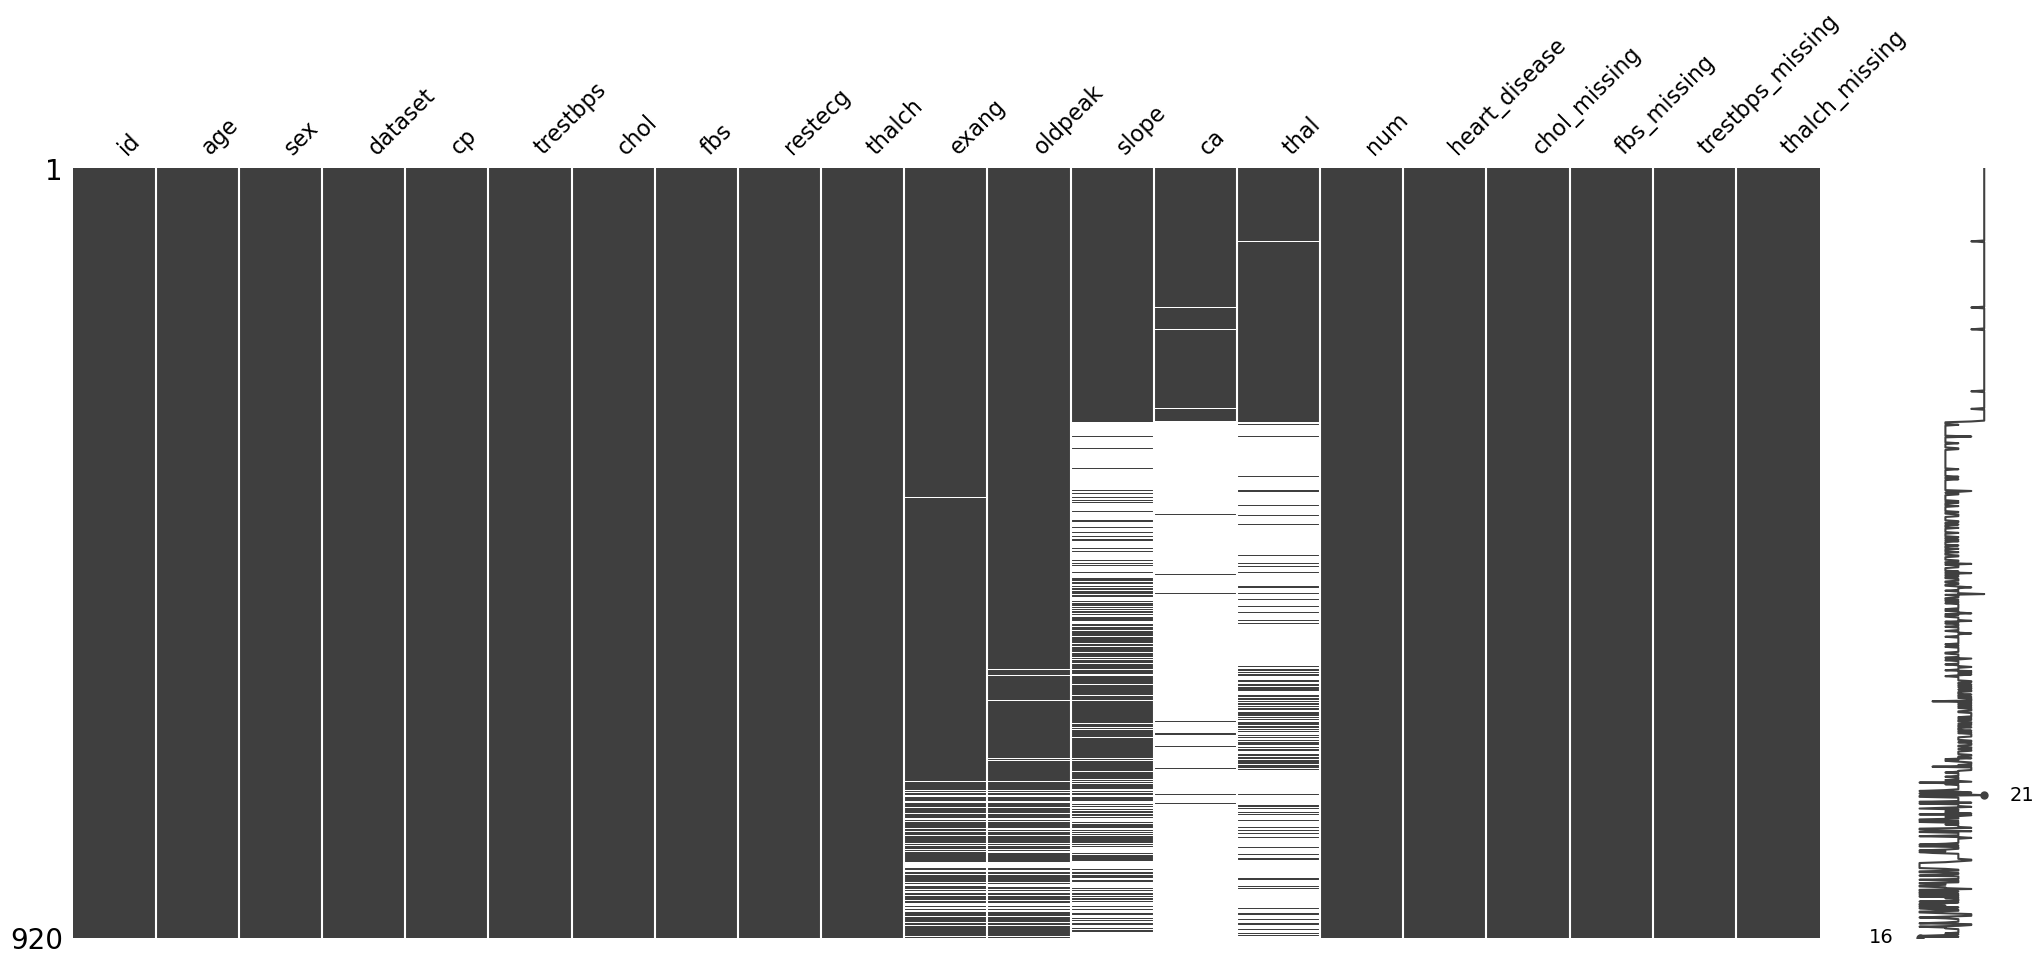

In [10]:
msno.matrix(df)

### EDA

This section provides a summary of data before encoding categorical variables.

In [11]:
print(f"Shape of the dataframe: {df.shape}")
print("\nData Types:")
print(df.dtypes)

Shape of the dataframe: (920, 21)

Data Types:
id                    int64
age                 float64
sex                 float64
dataset             float64
cp                   object
trestbps            float64
chol                float64
fbs                 float64
restecg              object
thalch              float64
exang                object
oldpeak             float64
slope                object
ca                  float64
thal                 object
num                   int64
heart_disease         int64
chol_missing          int64
fbs_missing           int64
trestbps_missing      int64
thalch_missing        int64
dtype: object


In [12]:
print("\nDescriptive Statistics:")
df.describe()


Descriptive Statistics:


,id,age,sex,dataset,trestbps,chol,fbs,thalch,oldpeak,ca,num,heart_disease,chol_missing,fbs_missing,trestbps_missing,thalch_missing
count,920.000000,920.000000,920.000000,920.000000,920.000000,920.000000,920.000000,920.000000,858.000000,309.000000,920.000000,920.000000,920.000000,920.000000,920.000000,920.000000
mean,460.500000,53.510870,0.789130,1.238043,132.271522,199.989348,0.161522,137.012609,0.878788,0.676375,0.995652,0.553261,0.032609,0.097826,0.064130,0.059783
std,265.725422,9.424685,0.408148,1.130673,18.652387,109.467366,0.356683,25.433566,1.091226,0.935653,1.142693,0.497426,0.177707,0.297241,0.245118,0.237213
min,1.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,230.750000,47.000000,1.000000,0.000000,120.000000,175.800000,0.000000,120.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,460.500000,54.000000,1.000000,1.000000,130.000000,223.500000,0.000000,139.000000,0.500000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,690.250000,60.000000,1.000000,2.000000,140.000000,268.000000,0.000000,156.000000,1.500000,1.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,920.000000,77.000000,1.000000,3.000000,200.000000,603.000000,1.000000,202.000000,6.200000,3.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [13]:
duplicates = df.duplicated().sum()
print(f"\nNumber of duplicate rows: {duplicates}")


Number of duplicate rows: 0


In [14]:
# Identify numeric and categorical columns
numeric_cols = ['age', 'chol', 'trestbps', 'thalch', 'oldpeak']
categorical_cols = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal', 'heart_disease']

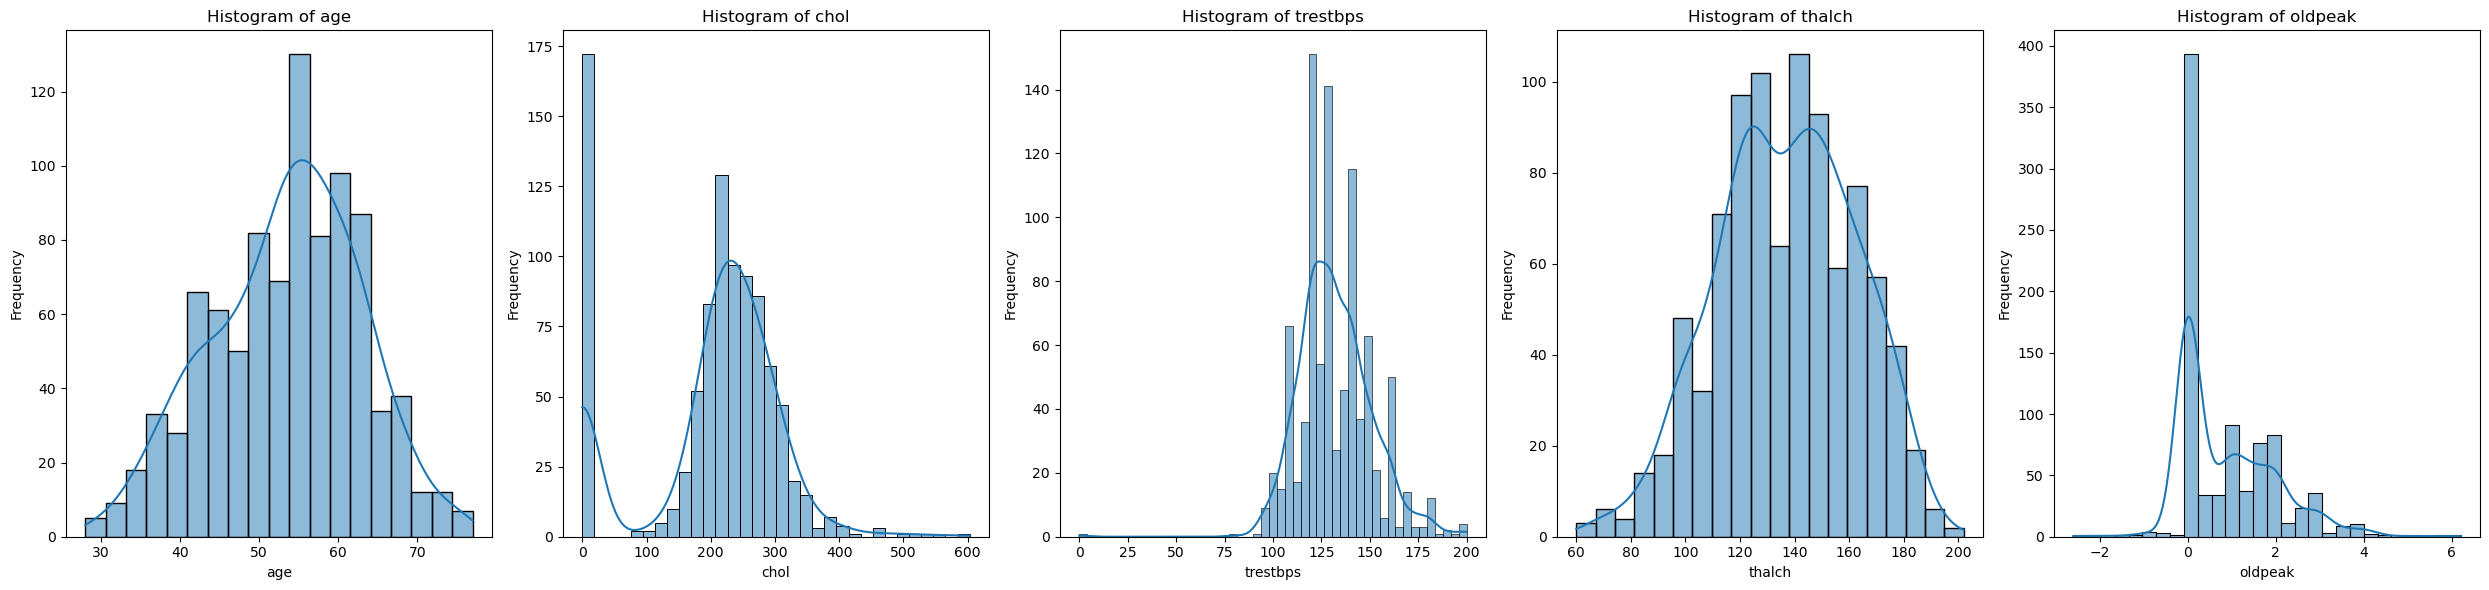

In [15]:
num_cols = len(numeric_cols)
fig, axes = plt.subplots(nrows=1, ncols=num_cols, figsize=(5 * num_cols, 6))

for ax, col in zip(axes, numeric_cols):
    sns.histplot(df[col], kde=True, ax=ax)
    ax.set_title(f'Histogram of {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

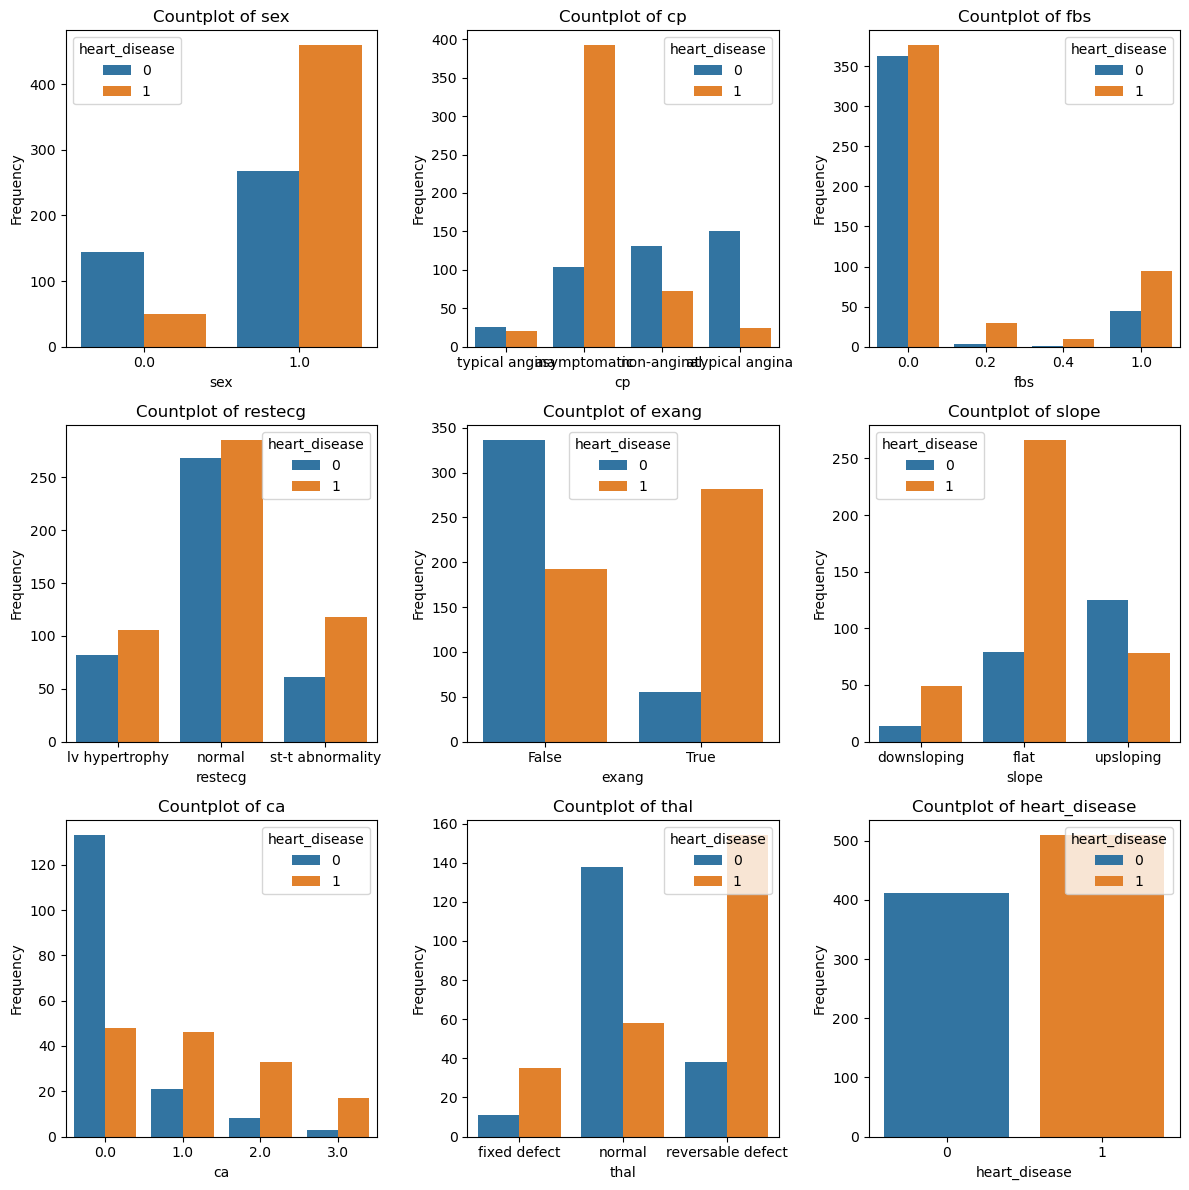

In [28]:
cat_cols = len(categorical_cols)
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 12))
axes = axes.flatten()
for ax, col in zip(axes, categorical_cols):
    sns.countplot(x=col, data=df, ax=ax, hue='heart_disease')
    ax.set_title(f'Countplot of {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

Correlation Matrix


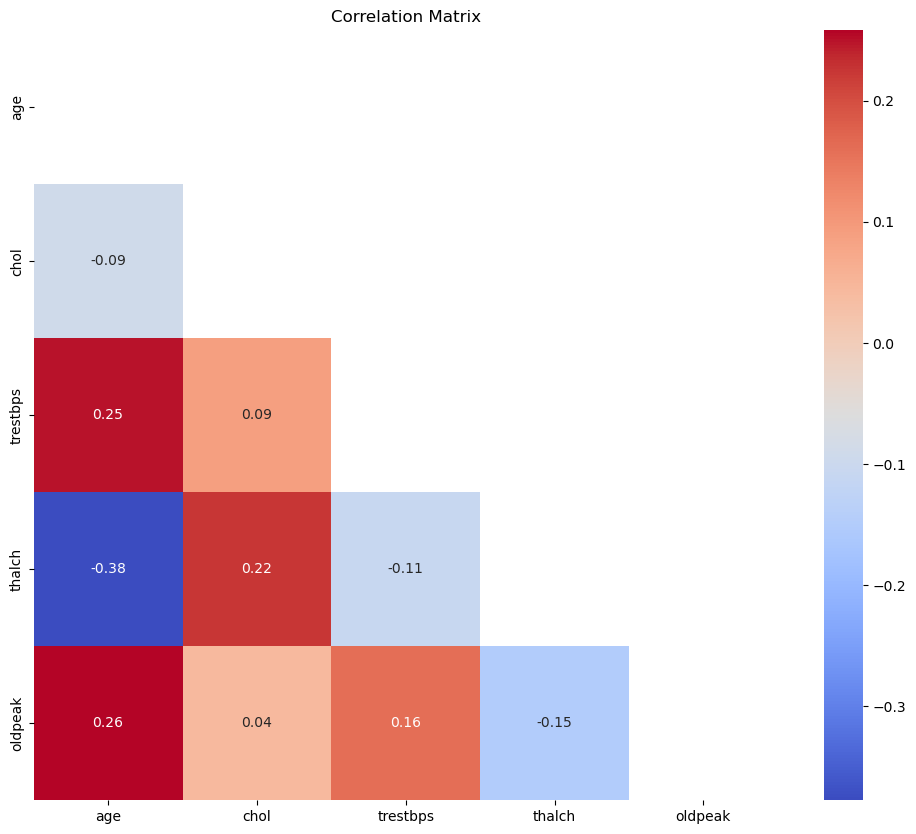

In [29]:
print("Correlation Matrix")

corr_matrix = df[numeric_cols].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", mask=np.triu(np.ones_like(corr_matrix, dtype=bool)))
plt.title('Correlation Matrix')
plt.show()

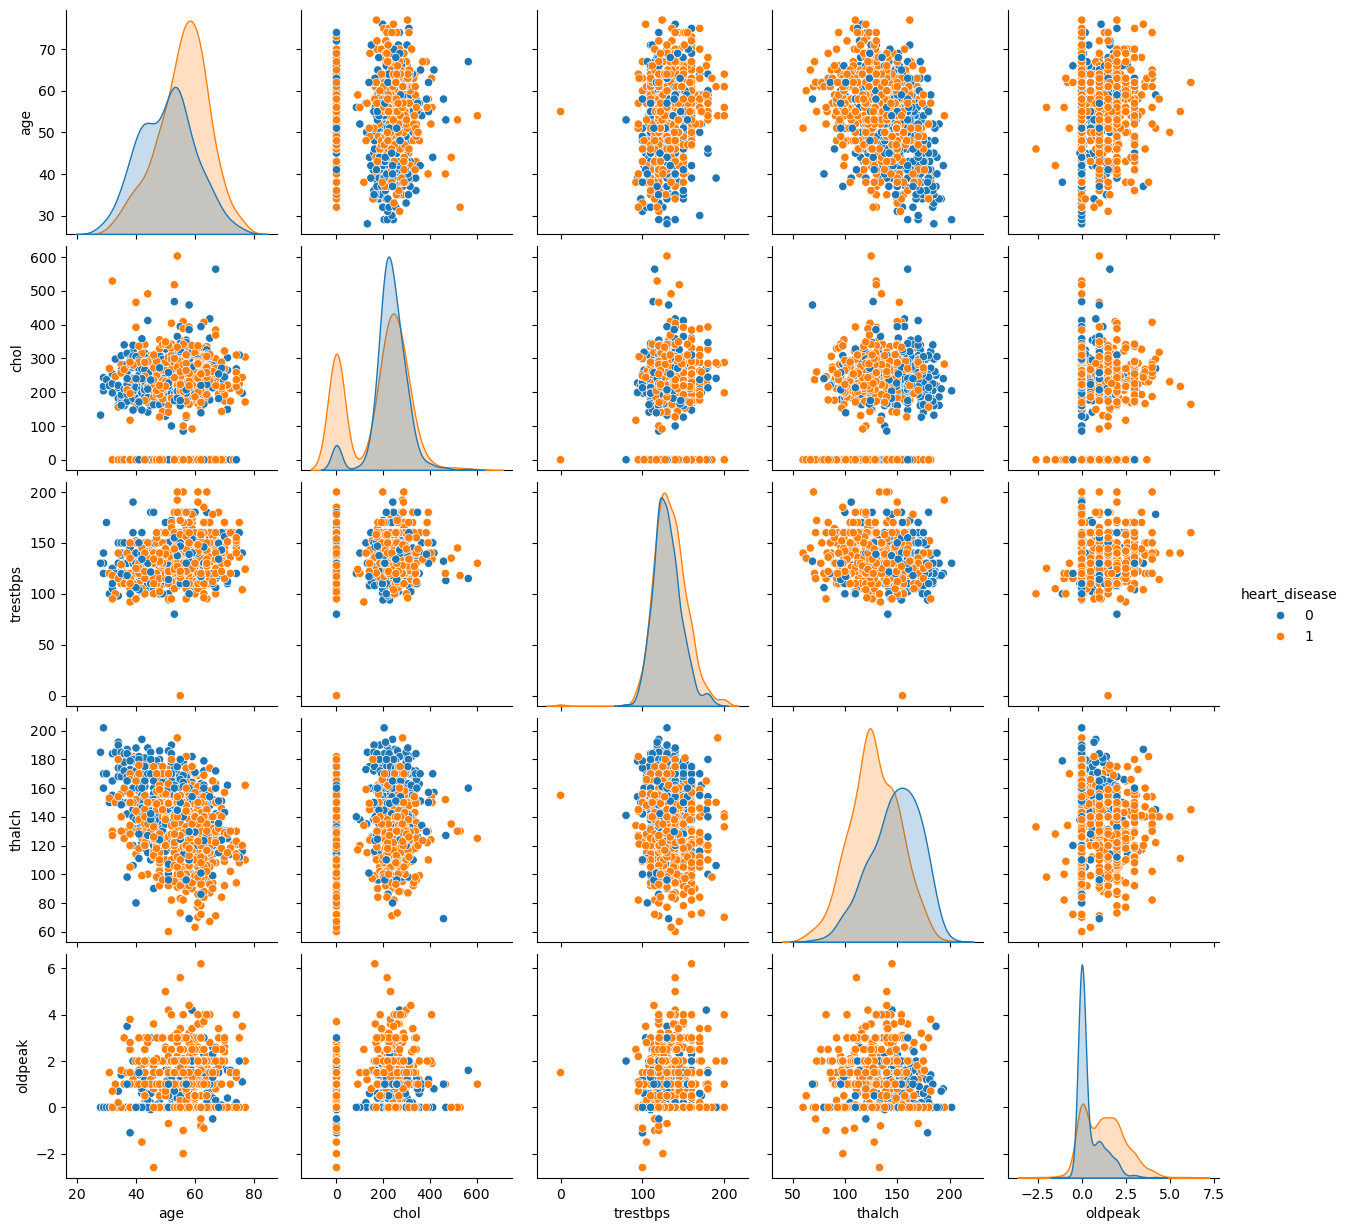

In [19]:
# Pairplot
sns.pairplot(df[numeric_cols + ['heart_disease']], hue='heart_disease')
plt.show()

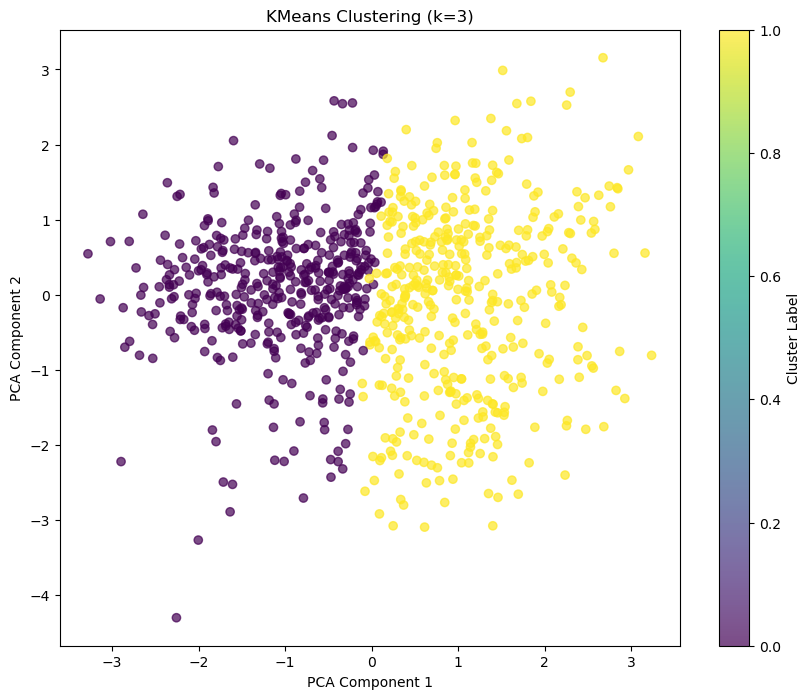

In [35]:
# Clustering Plot
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Prepare data for clustering
df_numeric = df[numeric_cols].dropna()

# Standardize the numerical data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_numeric)

# Reduce dimensions for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Perform KMeans clustering
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X_scaled)
labels = kmeans.labels_

# Plot the clusters
plt.figure(figsize=(10, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', alpha=0.7)
plt.title('KMeans Clustering (k=2)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster Label')
plt.show()

               age                              chol                          \
              mean       std   min   max        mean         std  min    max   
Cluster                                                                        
0        47.255220  7.847074  28.0  67.0  228.206032   88.378887  0.0  603.0   
1        59.058548  6.673389  39.0  77.0  174.725059  120.877535  0.0  458.0   

           trestbps                              thalch                   \
               mean        std   min    max        mean        std   min   
Cluster                                                                    
0        125.742459  16.025010   0.0  192.0  153.873318  19.062922  80.0   
1        138.532084  19.578737  95.0  200.0  121.283372  20.870420  60.0   

                 oldpeak                      
           max      mean       std  min  max  
Cluster                                       
0        202.0  0.419954  0.752095 -2.6  3.8  
1        180.0  1.341920  1.18

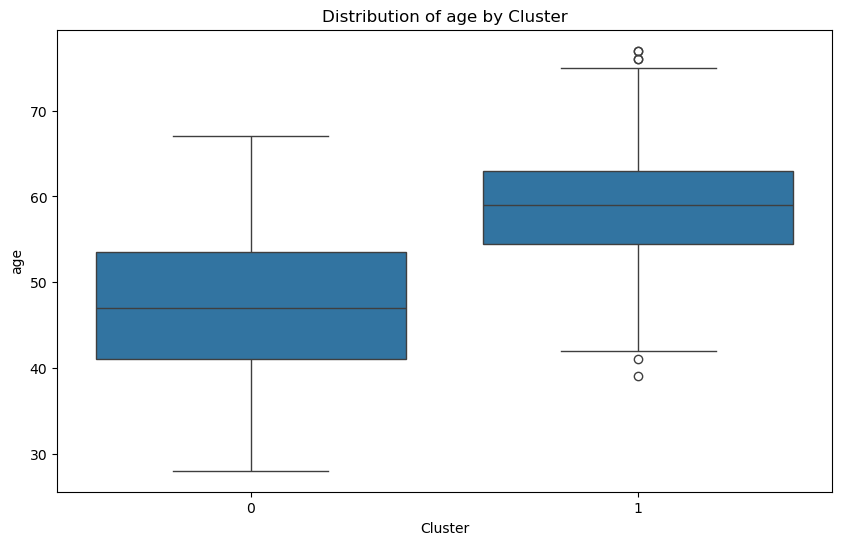

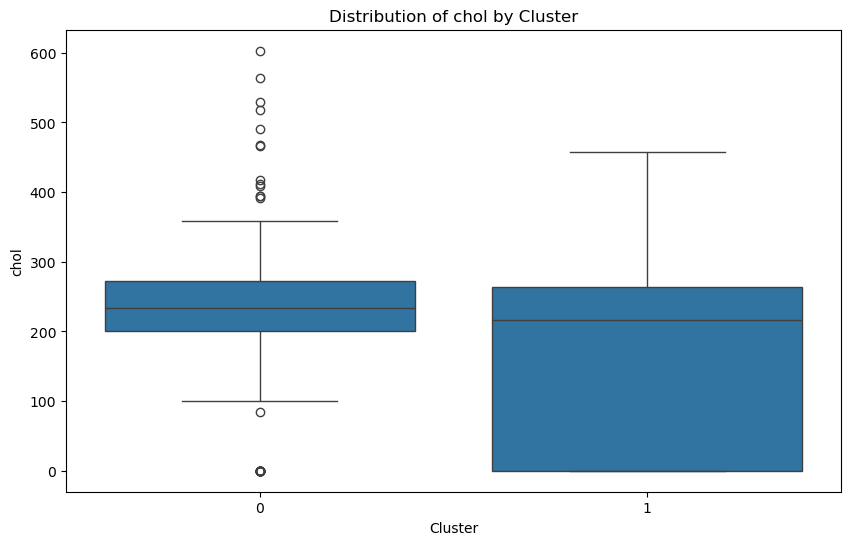

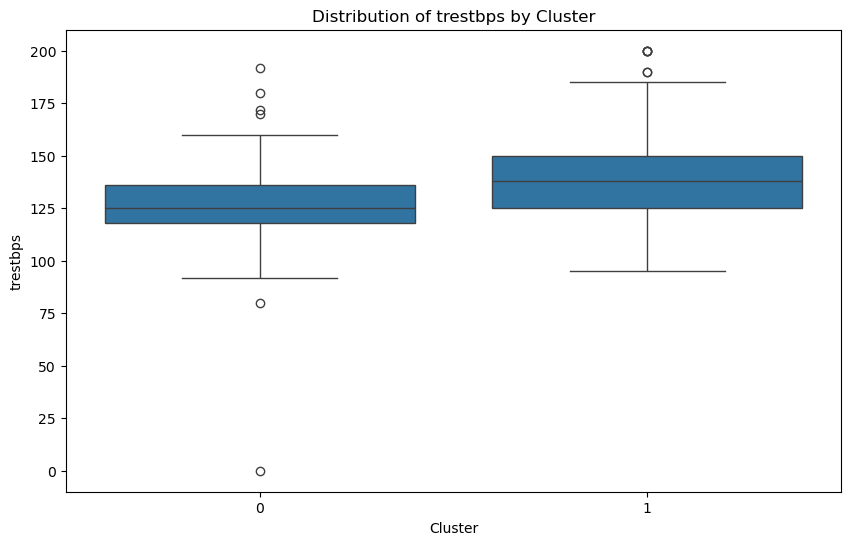

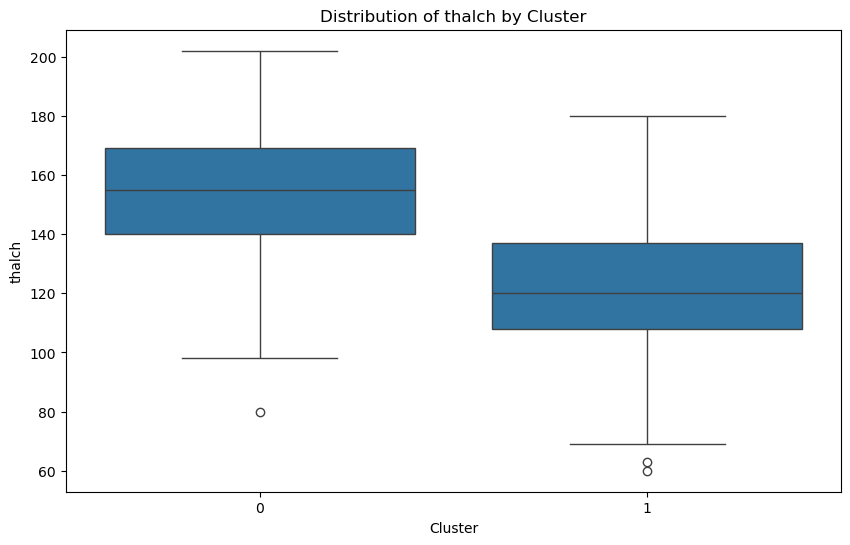

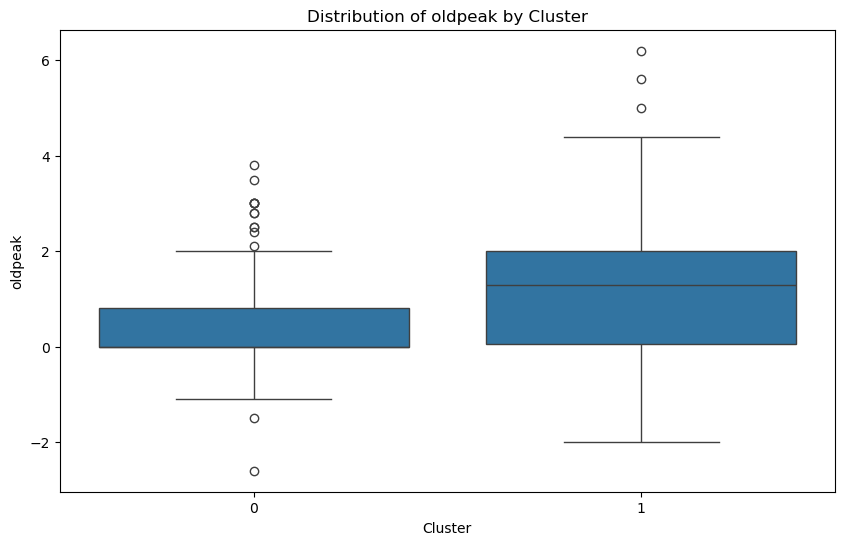

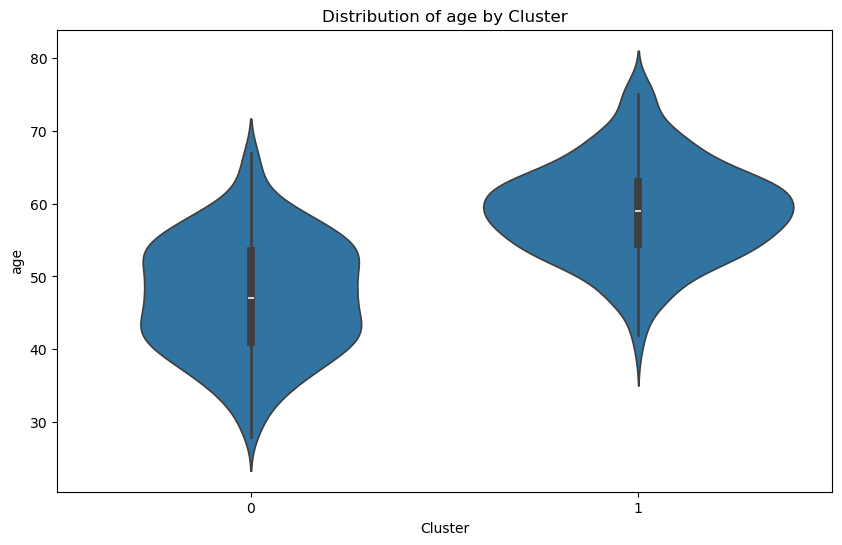

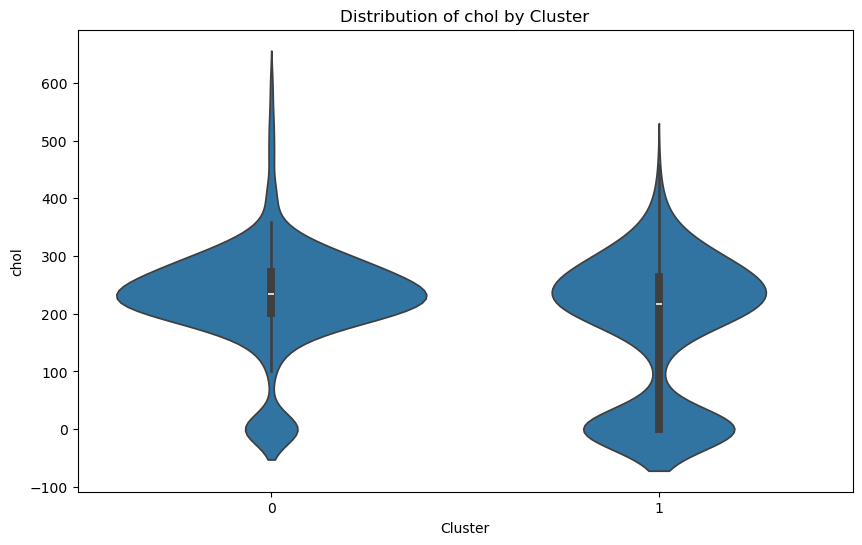

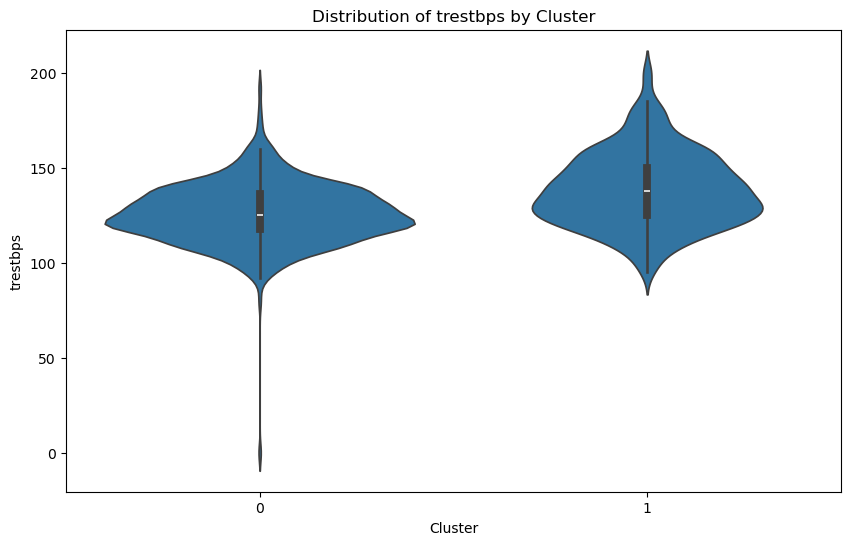

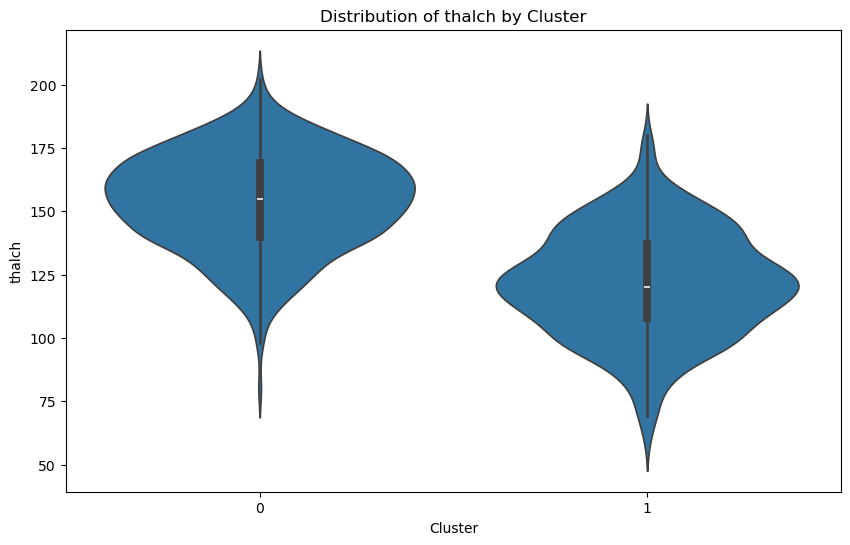

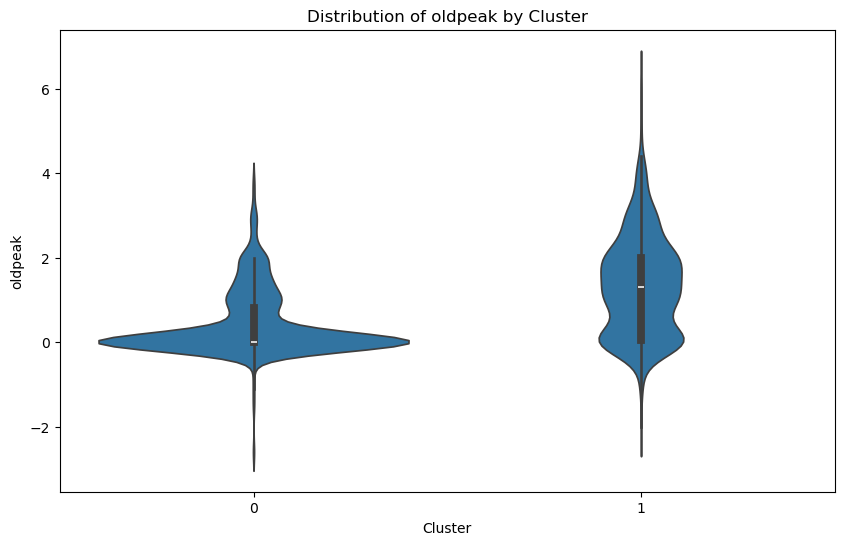

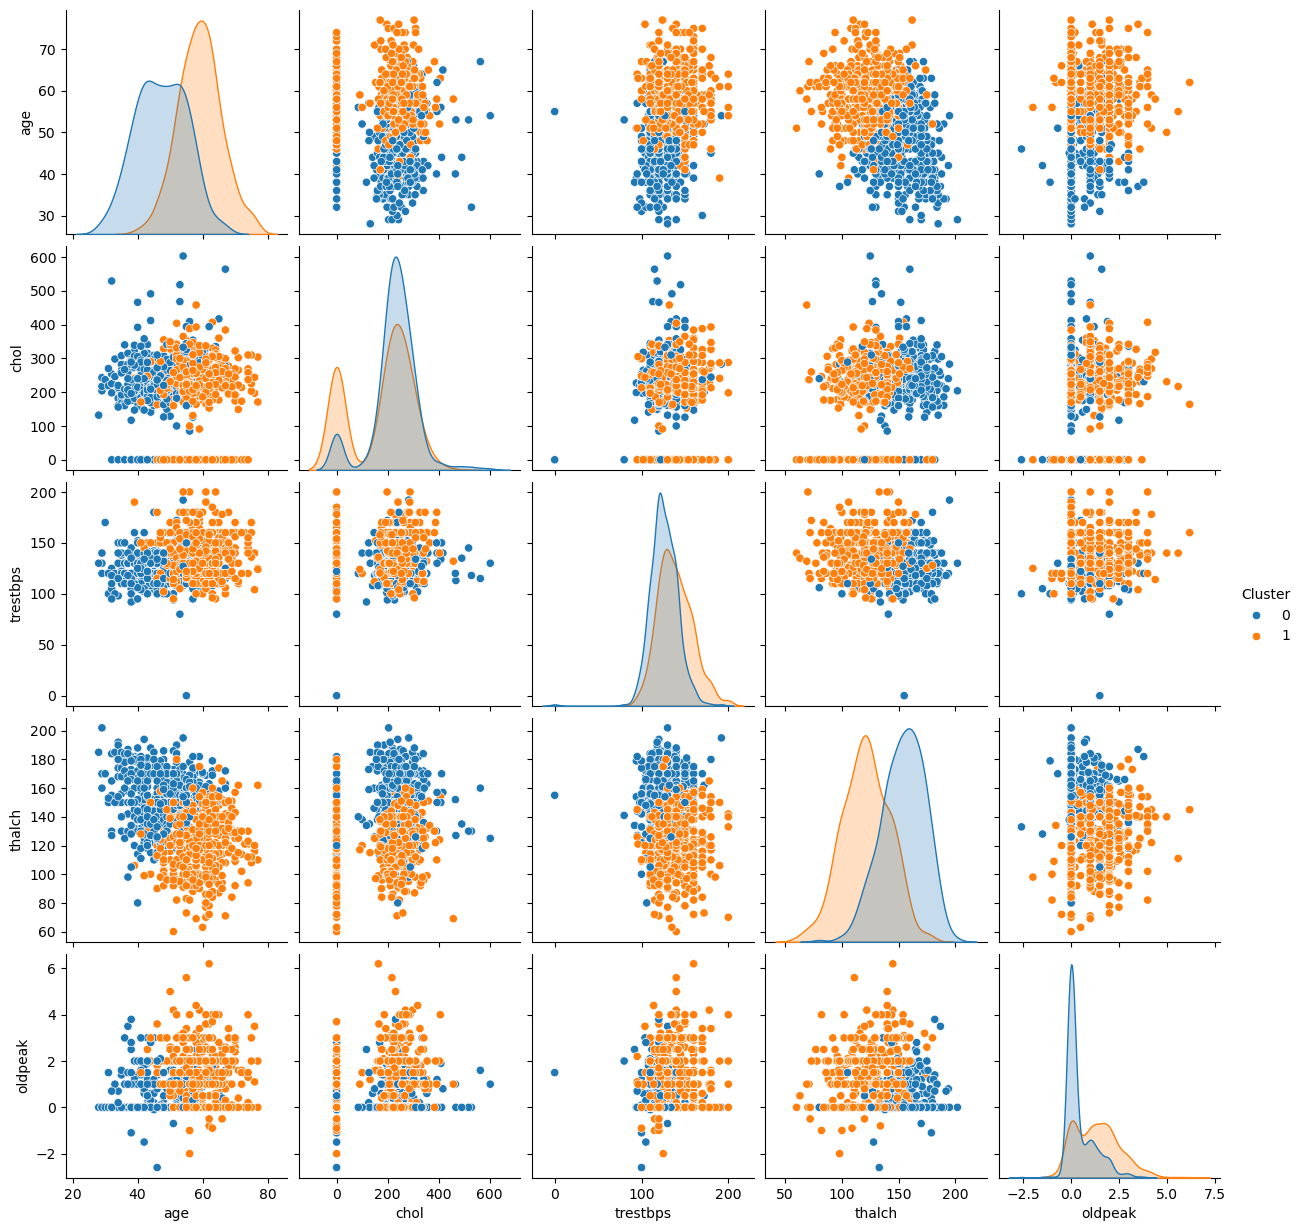

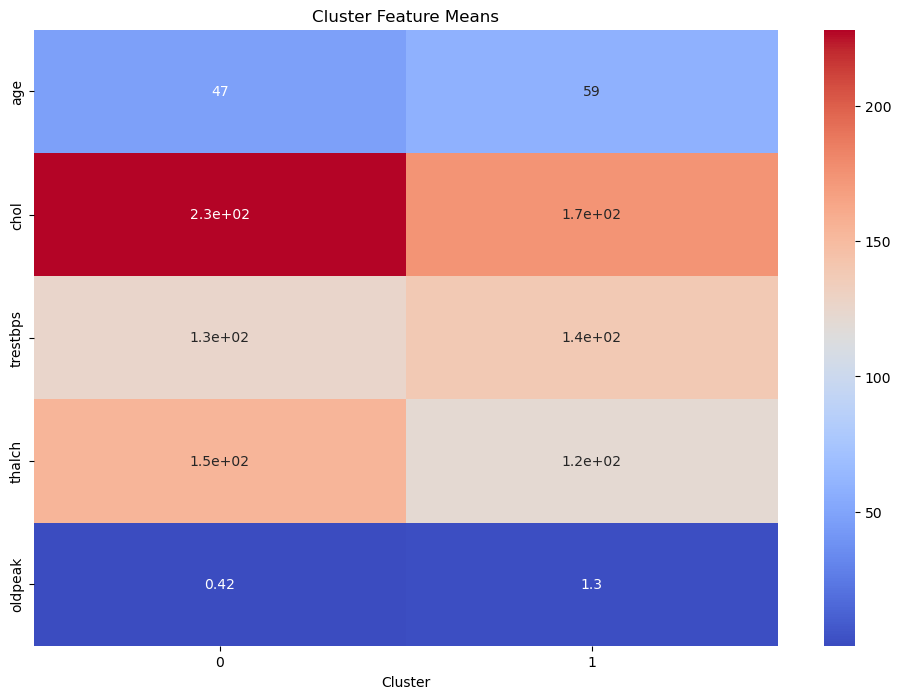

In [36]:
# Add cluster labels to the DataFrame
df_clustered = df_numeric.copy()
df_clustered['Cluster'] = labels

# Compute summary statistics for each cluster
cluster_summary = df_clustered.groupby('Cluster').agg(['mean', 'std', 'min', 'max'])
print(cluster_summary)

# Visualize distributions of features for each cluster using boxplots
for col in df_numeric.columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Cluster', y=col, data=df_clustered)
    plt.title(f'Distribution of {col} by Cluster')
    plt.show()

# Visualize distributions of features for each cluster using violin plots
for col in df_numeric.columns:
    plt.figure(figsize=(10, 6))
    sns.violinplot(x='Cluster', y=col, data=df_clustered)
    plt.title(f'Distribution of {col} by Cluster')
    plt.show()

# Pairplot of features colored by cluster labels
sns.pairplot(df_clustered, hue='Cluster', vars=df_numeric.columns)
plt.show()

# Heatmap of mean feature values per cluster
cluster_means = df_clustered.groupby('Cluster').mean()
plt.figure(figsize=(12, 8))
sns.heatmap(cluster_means.transpose(), annot=True, cmap='coolwarm')
plt.title('Cluster Feature Means')
plt.show()


In [38]:
df_clustered.shape

(858, 6)

In [42]:
df_clustered.index

Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
       ...
       908, 909, 910, 911, 912, 913, 914, 915, 917, 919],
      dtype='int64', length=858)

heart_disease    0    1
Cluster                
0              292  139
1               98  329


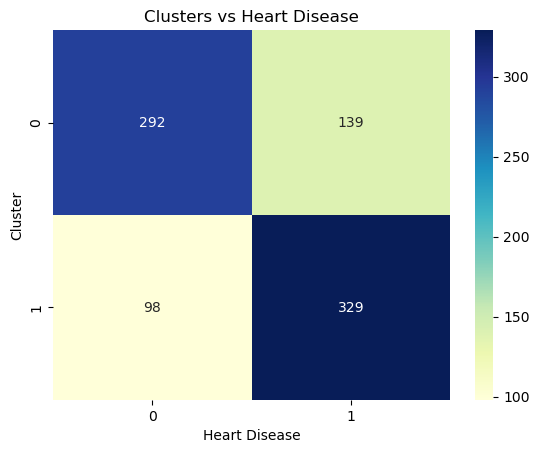

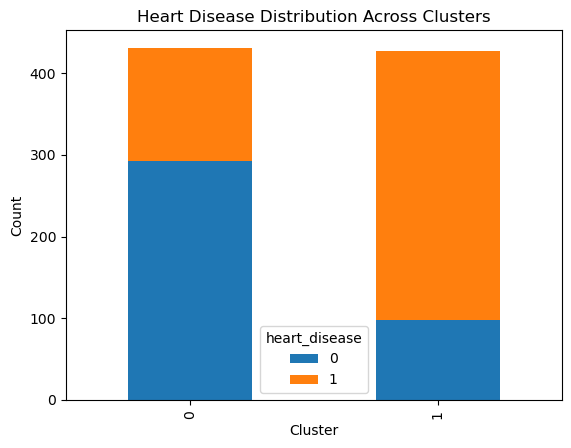

Chi-squared Test Statistic: 171.8222659030521
p-value: 2.959222004861667e-39


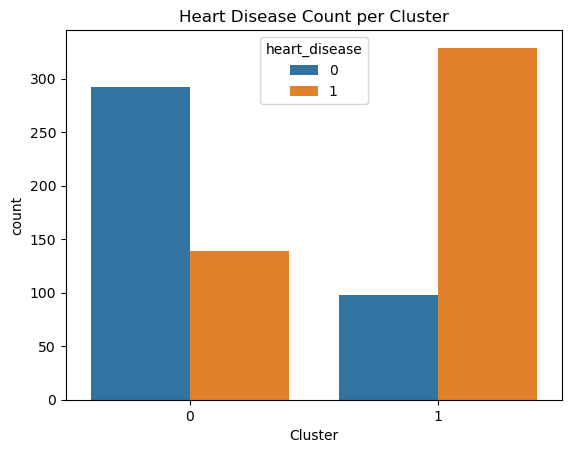

In [43]:
# Add cluster labels and heart_disease to the DataFrame
df_clustered = df_numeric.copy()
df_clustered['Cluster'] = labels
df_clustered['heart_disease'] = df.iloc[df_clustered.index, :]['heart_disease'].values

# Cross-tabulation of clusters and heart_disease
cluster_heart_crosstab = pd.crosstab(df_clustered['Cluster'], df_clustered['heart_disease'])
print(cluster_heart_crosstab)

# Heatmap of the relationship
sns.heatmap(cluster_heart_crosstab, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Clusters vs Heart Disease')
plt.ylabel('Cluster')
plt.xlabel('Heart Disease')
plt.show()

# Stacked bar chart
cluster_heart_crosstab.plot(kind='bar', stacked=True)
plt.title('Heart Disease Distribution Across Clusters')
plt.ylabel('Count')
plt.xlabel('Cluster')
plt.show()

# Chi-squared test
from scipy.stats import chi2_contingency

chi2, p, dof, expected = chi2_contingency(cluster_heart_crosstab)
print('Chi-squared Test Statistic:', chi2)
print('p-value:', p)

# Count plot of heart_disease per cluster
sns.countplot(data=df_clustered, x='Cluster', hue='heart_disease')
plt.title('Heart Disease Count per Cluster')
plt.show()


### Imputation

**Our way to deal with the missingness:**

1. For 'chol' and 'fbs', we will impute using 'age', 'sex', and 'dataset' to reflect the diet and local customary patterns of each site.

2. For 'restecg', only two values are missing; we will impute with the mode.

3. For 'trestbps', 'thalch', 'exang', and 'oldpeak', we plan to impute them using 'age' and 'sex'. We will perform a chained imputation of 'exang', 'slope', and 'oldpeak' using 'cp', resting EKG, and resting/stress test heart rates. We'll include a missingness indicator variable for these imputed variables.

4. For 'ca', it would not make sense to impute these variables. Instead, we will create a new categorical variable 'no_cath' to represent these patients and treat 'ca' as a categorical variable.

5. For 'thal', we decided not to impute a value based on the data distribution but instead create a new value 'no_stress'.

In [21]:
# Impute 'exang' and 'oldpeak'

# First, one-hot encode 'cp' and 'slope' for analysis here and in the future
df_imputed = pd.get_dummies(df, columns=['cp', 'slope','restecg'], prefix=['cp', 'slope','restecg'], drop_first=False)

# Create missingness indicator variables
df_imputed['slope'] = df_imputed['exang'].isnull().astype(int)
df_imputed['exang_missing'] = df_imputed['exang'].isnull().astype(int)
df_imputed['oldpeak_missing'] = df_imputed['oldpeak'].isnull().astype(int)

# Columns to impute --
ett_columns2 = ['trestbps', 'thalch', 'exang', 'oldpeak'] + [col for col in df_imputed.columns if col.startswith('cp_') or col.startswith('slope_') or col.startswith('restecg_')]

# Grab Columns
ett_data2 = df_imputed[ett_columns2]

#Initialize KNN Imputer (trial with n_neighbors as 5 --- we may need to experiment with adjusting this)
imputer = KNNImputer(n_neighbors=5)

#impute
imputed_ett_data2 = imputer.fit_transform(ett_data2)

#replace df-columns
# Replace Missing Values of 'ca' with 'no_cath'
df_imputed[ett_columns2] = imputed_ett_data2
df_imputed['ca'] = df_imputed['ca'].astype('string')
df_imputed['ca'] = df_imputed['ca'].fillna('no_cath')

# Replace Missing Values of 'thal' with 'no_stress"
df_imputed['thal'] = df_imputed['thal'].astype('string')
df_imputed['thal'] = df_imputed['thal'].fillna('no_stress')

In [22]:
# One-hot encode 'ca' and 'thal'
df_imputed = pd.get_dummies(df_imputed, columns=['ca', 'thal'], prefix=['ca', 'thal'], drop_first=True)

In [23]:
# Drop columns we won't use for modeling, copy to new df_imputed:
df_imputed = df_imputed.drop(columns=['id', 'dataset', 'num']).copy()

<Axes: >

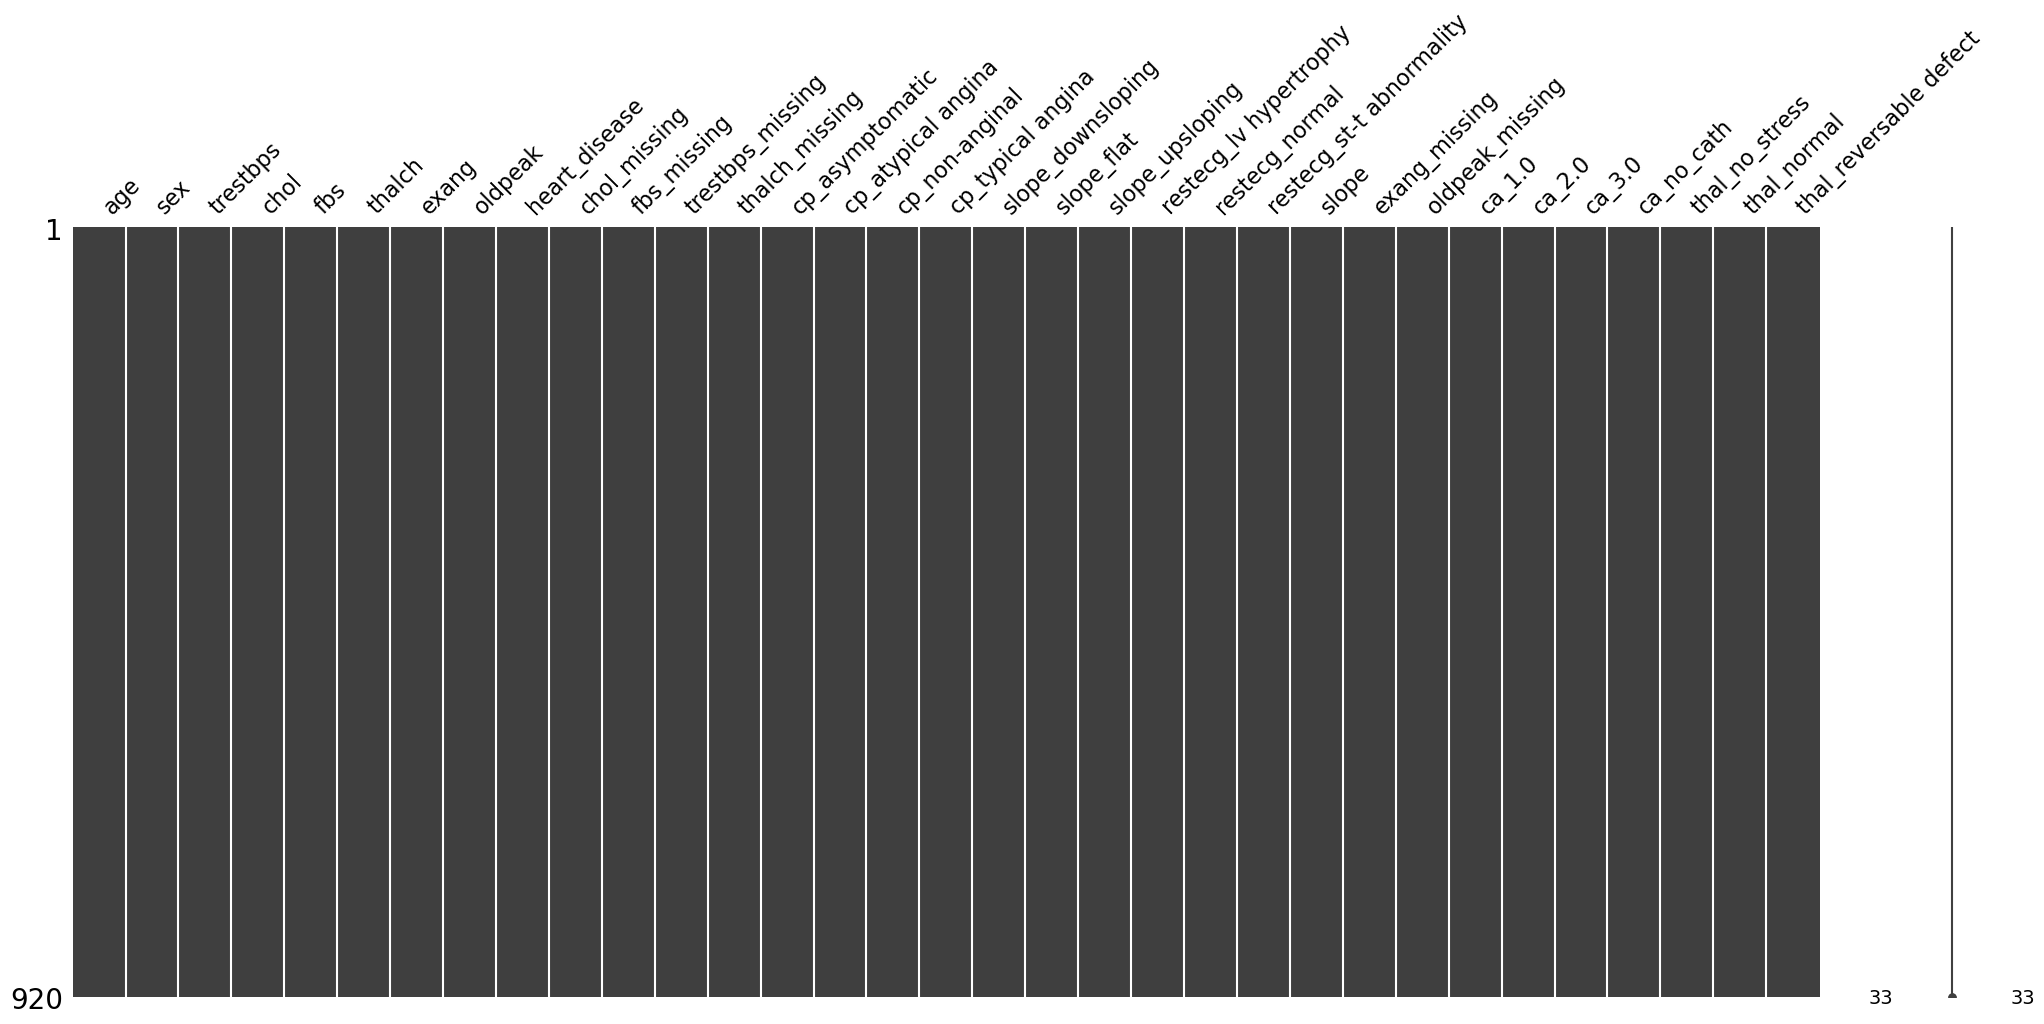

In [24]:
msno.matrix(df_imputed)

In [25]:
#Train/test split, convert to X and y df
X = df_imputed.drop(columns='heart_disease')
y = df_imputed['heart_disease']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=317)

### Baseline model

In [26]:
y_pred_baseline = np.ones(y_test.shape)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_test, y_pred_baseline)
precision = precision_score(y_test, y_pred_baseline)
recall = recall_score(y_test, y_pred_baseline)
f1 = f1_score(y_test, y_pred_baseline)

print(f"Baseline Model Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

baseline_model = y_pred_baseline

Baseline Model Performance:
Accuracy: 0.5543
Precision: 0.5543
Recall: 1.0000
F1-score: 0.7133
